In [ ]:
import transformers
print(transformers.__version__)


4.57.1


In [ ]:
!pip install -q evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


XÂY DỰNG MÔ HÌNH NHẬN DẠNG LỆNH ĐIỀU KHIỂN ROBOT

In [ ]:
import json
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Trainer, TrainingArguments
)
import evaluate

In [ ]:
import json

file_path = "/content/sample_data/voice2command_dataset_vi_50k.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

print(f"Số dòng đọc được: {len(lines)}")
print("Mẫu dòng đầu tiên:")
print(lines[0][:300])


Số dòng đọc được: 50000
Mẫu dòng đầu tiên:
{"text": "tới gần tủ lạnh tím  bên phải", "intent": "move_to_object", "object": "tủ lạnh", "color": "tím", "direction": "phải", "distance": null}



In [ ]:
import json
import os
from tqdm import tqdm

paths = [
    "/content/sample_data/voice2command_dataset_vi_20k.jsonl",
    "/content/sample_data/voice2command_dataset_vi_50k.jsonl"
]

merged = []

for path in paths:
    if not os.path.exists(path):
        print(f"⚠️ File không tồn tại: {path}")
        continue

    count = 0
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                item = json.loads(line.strip())

                # --- Trường hợp file kiểu 20k (đã có input/output) ---
                if "input" in item and "output" in item:
                    merged.append(item)
                    count += 1

                # --- Trường hợp file kiểu 50k (chỉ có text + intent...) ---
                elif "text" in item and "intent" in item:
                    merged.append({
                        "input": item["text"],
                        "output": {
                            "intent": item.get("intent"),
                            "object": item.get("object"),
                            "color": item.get("color"),
                            "direction": item.get("direction"),
                            "distance": item.get("distance"),
                        }
                    })
                    count += 1

            except Exception as e:
                print(f"Lỗi đọc dòng: {e}")

    print(f"✅ Đã đọc {count:,} mẫu từ {os.path.basename(path)}")

# --- Loại trùng (nếu có) ---
unique = {json.dumps(d, ensure_ascii=False): d for d in merged}
merged = list(unique.values())

print(f"\n Tổng số mẫu sau khi gộp & loại trùng: {len(merged):,}")

# --- Xem thử vài mẫu ---
import random
for i in random.sample(range(min(len(merged), 3)), 3):
    print(f"\n Lệnh: {merged[i]['input']}")
    print(f" JSON: {merged[i]['output']}")

# --- Lưu file gộp ---
with open("/content/sample_data/voice2command_dataset_vi_merged.jsonl", "w", encoding="utf-8") as f:
    for item in merged:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print("\n Đã lưu file gộp: /content/sample_data/voice2command_dataset_vi_merged.jsonl")


✅ Đã đọc 20,000 mẫu từ voice2command_dataset_vi_20k.jsonl
✅ Đã đọc 50,000 mẫu từ voice2command_dataset_vi_50k.jsonl

 Tổng số mẫu sau khi gộp & loại trùng: 48,839

 Lệnh: hãy đi thẳng thêm 1.3 mét
 JSON: {"intent": "navigate", "object": null, "color": null, "direction": null, "distance": 1.3}

 Lệnh: tiến lên mét
 JSON: {"intent": "navigate", "object": null, "color": null, "direction": null, "distance": null}

 Lệnh: lùi lại 2.7 mét
 JSON: {"intent": "navigate", "object": null, "color": null, "direction": null, "distance": 2.7}

 Đã lưu file gộp: /content/sample_data/voice2command_dataset_vi_merged.jsonl


✅ Đã đọc 20000 dòng từ /content/sample_data/voice2command_dataset_vi_20k.jsonl
✅ Đã đọc 50000 dòng từ /content/sample_data/voice2command_dataset_vi_50k.jsonl

📊 Tổng số mẫu sau khi gộp & loại trùng nhẹ: 45,984

🗣️ Câu lệnh: tới gần hơn sách xanh  bên gần khoảng 2.35 mét
➡️ Đầu ra JSON: {"intent": "navigate", "object": "sách", "color": "xanh", "direction": "gần", "distance": 2.35}

🗣️ Câu lệnh: tới gần tủ lạnh đen  bên trước khoảng 4.18 mét
➡️ Đầu ra JSON: {"intent": "navigate", "object": "tủ lạnh", "color": "đen", "direction": "trước", "distance": 4.18}

🗣️ Câu lệnh: nhìn về phía cốc trắng  bên xa
➡️ Đầu ra JSON: {"intent": "navigate", "object": "cốc", "color": "trắng", "direction": "xa", "distance": null}


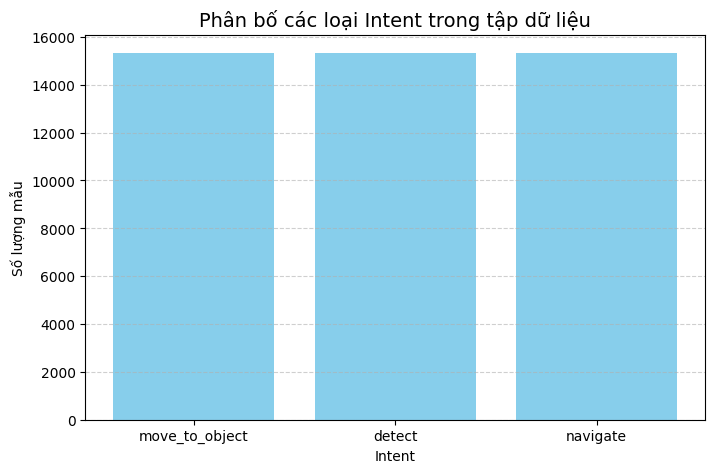


📋 Thống kê nhanh:
              input          intent object  color direction      distance
count         45984           45983  45983  41745     39333  24923.000000
unique        40260               3     20     10         6           NaN
top     đến bàn nâu  move_to_object    bút    nâu        xa           NaN
freq              3           15335   2381   4230      6618           NaN
mean            NaN             NaN    NaN    NaN       NaN      2.762185
std             NaN             NaN    NaN    NaN       NaN      1.302025
min             NaN             NaN    NaN    NaN       NaN      0.500000
25%             NaN             NaN    NaN    NaN       NaN      1.640000
50%             NaN             NaN    NaN    NaN       NaN      2.780000
75%             NaN             NaN    NaN    NaN       NaN      3.890000
max             NaN             NaN    NaN    NaN       NaN      5.000000

🎯 Một vài ví dụ phổ biến theo intent:
                                               input  

In [ ]:
import json
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter

# --- Đọc dữ liệu từ hai file ---
paths = [
    "/content/sample_data/voice2command_dataset_vi_20k.jsonl",
    "/content/sample_data/voice2command_dataset_vi_50k.jsonl"
]

data = []
for path in paths:
    try:
        with open(path, "r", encoding="utf-8") as f:
            lines = f.readlines()
        print(f"✅ Đã đọc {len(lines)} dòng từ {path}")

        for line in lines:
            try:
                item = json.loads(line.strip())
                # Đảm bảo có cả input/output
                data.append({
                    "input": item.get("text", "").strip(),
                    "output": {
                        "intent": item.get("intent"),
                        "object": item.get("object"),
                        "color": item.get("color"),
                        "direction": item.get("direction"),
                        "distance": item.get("distance")
                    }
                })
            except json.JSONDecodeError:
                continue
    except FileNotFoundError:
        print(f"⚠️ Không tìm thấy file: {path}")

# --- Gộp và loại trùng nhẹ (nếu có) ---
unique_data = {json.dumps(d, ensure_ascii=False): d for d in data}  # loại trùng hẳn dòng
data = list(unique_data.values())

print(f"\n📊 Tổng số mẫu sau khi gộp & loại trùng nhẹ: {len(data):,}")

# --- Xem thử 3 mẫu ngẫu nhiên ---
for i in random.sample(range(len(data)), 3):
    print(f"\n🗣️ Câu lệnh: {data[i]['input']}")
    print(f"➡️ Đầu ra JSON: {json.dumps(data[i]['output'], ensure_ascii=False)}")

# --- Thống kê các intent ---
intents = [d["output"]["intent"] for d in data if d["output"].get("intent")]
intent_counts = Counter(intents)

plt.figure(figsize=(8,5))
plt.bar(intent_counts.keys(), intent_counts.values(), color="skyblue")
plt.title("Phân bố các loại Intent trong tập dữ liệu", fontsize=14)
plt.xlabel("Intent")
plt.ylabel("Số lượng mẫu")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# --- Tạo DataFrame để quan sát ---
df = pd.DataFrame([{
    "input": d["input"],
    "intent": d["output"].get("intent", ""),
    "object": d["output"].get("object", ""),
    "color": d["output"].get("color", ""),
    "direction": d["output"].get("direction", ""),
    "distance": d["output"].get("distance", "")
} for d in data])

print("\n📋 Thống kê nhanh:")
print(df.describe(include='all'))

print("\n🎯 Một vài ví dụ phổ biến theo intent:")
print(df.groupby("intent").head(2).reset_index(drop=True))


In [ ]:
import pandas as pd
import re

# ✅ 1️⃣ LÀM SẠCH DỮ LIỆU (Clean Text)
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Chuyển về chữ thường và bỏ ký tự đặc biệt (giữ lại tiếng Việt)
    text = text.lower().strip()
    text = re.sub(r"[^\w\sáàảãạăắằẳẵặâấầẩẫậđéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵ]", "", text)
    text = re.sub(r"\s+", " ", text)  # bỏ khoảng trắng thừa
    return text

df["input_clean"] = df["input"].apply(clean_text)

print("🔹 Ví dụ sau khi làm sạch:")
print(df[["input", "input_clean"]].head(5))

# ✅ 2️⃣ CHUẨN HÓA CÁC GIÁ TRỊ KHÔNG HỢP LỆ / NaN
# - intent: giữ nguyên nếu thiếu
# - distance: điền 0 nếu không có
# - các cột khác: điền chuỗi rỗng
df["intent"] = df["intent"].fillna("")
df["object"] = df["object"].fillna("")
df["color"] = df["color"].fillna("")
df["direction"] = df["direction"].fillna("")
df["distance"] = df["distance"].fillna(0.0)

# ✅ 3️⃣ THÊM CÁC CỘT THỐNG KÊ & ĐẶC TRƯNG MỚI
df["len_tokens"] = df["input_clean"].apply(lambda x: len(x.split()))         # số từ
df["has_color"] = df["color"].apply(lambda x: x != "")                       # có màu hay không
df["has_direction"] = df["direction"].apply(lambda x: x != "")               # có hướng hay không
df["has_distance"] = df["distance"].apply(lambda x: x > 0)                   # có khoảng cách hay không
df["has_object"] = df["object"].apply(lambda x: x != "")                     # có vật thể hay không

# ✅ 4️⃣ THỐNG KÊ NHANH
print("\n📊 Thống kê độ dài câu lệnh:")
print(df["len_tokens"].describe())

print("\n📊 Tỷ lệ có đặc trưng:")
print(df[["has_object", "has_color", "has_direction", "has_distance"]].mean() * 100)

# ✅ 5️⃣ HIỂN THỊ MỘT VÀI MẪU
print("\n🔍 Một vài mẫu sau xử lý:")
print(df.sample(5)[["input_clean", "intent", "object", "color", "direction", "distance", "len_tokens"]])


🔹 Ví dụ sau khi làm sạch:
                                               input  \
0                                                      
1                      tới gần tủ lạnh tím  bên phải   
2                    nhìn về phía tivi tím  bên phải   
3          nhìn về phía mèo  bên phải khoảng 2.7 mét   
4  tới gần hơn điện thoại trắng  bên xa khoảng 2....   

                                         input_clean  
0                                                     
1                       tới gần tủ lạnh tím bên phải  
2                     nhìn về phía tivi tím bên phải  
3            nhìn về phía mèo bên phải khoảng 27 mét  
4  tới gần hơn điện thoại trắng bên xa khoảng 206...  

📊 Thống kê độ dài câu lệnh:
count    45984.000000
mean         7.580332
std          1.830052
min          0.000000
25%          6.000000
50%          8.000000
75%          9.000000
max         11.000000
Name: len_tokens, dtype: float64

📊 Tỷ lệ có đặc trưng:
has_object       99.997825
has_color        90

In [ ]:
print(df.groupby(["intent", "object"]).size().sort_values(ascending=False).head(10))


intent          object    
detect          cửa           819
                bút           814
navigate        xe            808
                sách          801
detect          đèn           801
move_to_object  ghế sofa      798
                điện thoại    797
navigate        cốc           795
                đèn           794
move_to_object  cây           793
dtype: int64


In [ ]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

# --- Chuẩn bị dữ liệu đầu vào / đầu ra ---
pairs = [
    {"input": d["input"], "output": json.dumps(d["output"], ensure_ascii=False)}
    for d in data
]

# --- Chia dữ liệu ---
train_data, test_data = train_test_split(pairs, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)

print(f"📂 Số mẫu huấn luyện: {len(train_dataset)}")
print(f"📂 Số mẫu kiểm định: {len(val_dataset)}")
print(f"📂 Số mẫu kiểm tra: {len(test_dataset)}")


📂 Số mẫu huấn luyện: 37246
📂 Số mẫu kiểm định: 4139
📂 Số mẫu kiểm tra: 4599


In [ ]:
from transformers import AutoTokenizer
import numpy as np
import json

# ✅ 1. Khởi tạo tokenizer
model_name = "VietAI/vit5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ 2. Chuẩn hóa output JSON sang dạng dễ học (vì mô hình khó sinh JSON thô)
def simplify_output(text):
    try:
        data = json.loads(text)
        return "; ".join([f"{k}: {v if v is not None else 'none'}" for k, v in data.items()])
    except Exception:
        return text

# ✅ 3. Tiền xử lý dữ liệu
def preprocess(examples):
    # Làm phẳng dữ liệu nếu cần
    inputs = [ex for ex in examples["input"]]
    outputs = [simplify_output(ex) for ex in examples["output"]]

    # Token hóa input
    model_inputs = tokenizer(
        inputs,
        max_length=128,
        truncation=True,
        padding="max_length",
    )

    # Token hóa output (mục tiêu)
    labels = tokenizer(
        outputs,
        max_length=128,
        truncation=True,
        padding="max_length",
    )

    # 🔥 Chuyển token PAD thành -100 để không tính vào loss
    labels["input_ids"] = [
        [(t if t != tokenizer.pad_token_id else -100) for t in seq]
        for seq in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


# ✅ 4. Tiền xử lý nhanh bằng map song song
train_dataset = train_dataset.map(
    preprocess,
    batched=True,
    remove_columns=train_dataset.column_names,
    num_proc=2,
    desc="🔁 Encoding train set",
)

val_dataset = val_dataset.map(
    preprocess,
    batched=True,
    remove_columns=val_dataset.column_names,
    num_proc=2,
    desc="🔁 Encoding validation set",
)

test_dataset = test_dataset.map(
    preprocess,
    batched=True,
    remove_columns=test_dataset.column_names,
    num_proc=2,
    desc="🔁 Encoding test set",
)

print("✅ Dữ liệu đã được mã hóa và chuẩn hóa token thành công!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

🔁 Encoding train set (num_proc=2):   0%|          | 0/37246 [00:00<?, ? examples/s]

🔁 Encoding validation set (num_proc=2):   0%|          | 0/4139 [00:00<?, ? examples/s]

🔁 Encoding test set (num_proc=2):   0%|          | 0/4599 [00:00<?, ? examples/s]

✅ Dữ liệu đã được mã hóa và chuẩn hóa token thành công!


In [ ]:
# ✅ 5. Kiểm tra nhanh kết quả tiền xử lý
print("\n🔍 Kiểm tra mẫu sau khi mã hóa:")
sample = train_dataset[0]

# Lấy lại chuỗi gốc và chuỗi mã hóa
input_ids = sample["input_ids"]
label_ids = sample["labels"]

# Giải mã token -> text để kiểm tra
decoded_input = tokenizer.decode([t for t in input_ids if t != tokenizer.pad_token_id])
decoded_label = tokenizer.decode([t for t in label_ids if t != -100 and t != tokenizer.pad_token_id])

print(f"\n Input gốc: {decoded_input}")
print(f" Output gốc (label): {decoded_label}")

# Kiểm tra có bao nhiêu token hợp lệ trong label
valid_tokens = np.sum(np.array(label_ids) != -100)
print(f"\n Số token hợp lệ trong nhãn (label): {valid_tokens}")
print(" Token hóa dữ liệu ổn định nếu valid_tokens > 0\n")

# Nếu cần xem trực quan hơn:
print(f" Mã token input (rút gọn): {input_ids[:30]} ...")
print(f" Mã token label (rút gọn): {label_ids[:30]} ...")



🔍 Kiểm tra mẫu sau khi mã hóa:

 Input gốc: đi tới máy tính đen bên xa khoảng 3.03 mét</s>
 Output gốc (label): intent: detect; object: máy tính; color: đen; direction: xa; distance: 3.03</s>

 Số token hợp lệ trong nhãn (label): 29
 Token hóa dữ liệu ổn định nếu valid_tokens > 0

 Mã token input (rút gọn): [352, 484, 417, 782, 1747, 790, 1566, 676, 122, 35792, 35846, 35879, 2129, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ...
 Mã token label (rút gọn): [11483, 1328, 35862, 24455, 3525, 35899, 5393, 6689, 35862, 417, 782, 35899, 10909, 35862, 1747, 35899, 28829, 1363, 35862, 1566, 35899, 35, 28153, 35862, 122, 35792, 35846, 35879, 1, -100] ...


In [ ]:
# ---------------------- Preparations ----------------------
import os, torch, json, evaluate
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)

os.environ["WANDB_DISABLED"] = "true"

#  Model
model_name = "VietAI/vit5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

#  Data collator (chuẩn cho Seq2Seq)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

#  Metrics
bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")

def postprocess_texts(texts):
    return [t.strip() for t in texts]

def compute_metrics_from_preds(preds, labels):
    preds = postprocess_texts(preds)
    labels = postprocess_texts(labels)
    bleu = bleu_metric.compute(predictions=preds, references=[[l] for l in labels])
    rouge = rouge_metric.compute(predictions=preds, references=labels)
    return {
        "bleu": round(bleu["score"], 2),
        "rougeL": round(rouge["rougeL"], 4)
    }

# ---------------------- TrainingArguments ----------------------
batch_size = 8
grad_accum = 2

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/robot_seq2seq",
    overwrite_output_dir=True,
    num_train_epochs=8,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    save_strategy="epoch",
    eval_strategy="epoch",   # thay vì evaluation_strategy
    logging_strategy="steps",
    logging_steps=50,
    predict_with_generate=True,
    fp16=True,
    gradient_accumulation_steps=2,
)


# ---------------------- Seq2SeqTrainer ----------------------
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,    # dataset đã được token hóa và set_format("torch")
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# ---------------------- Training ----------------------
trainer.train()

# ---------------------- Evaluation ----------------------
pred = trainer.predict(test_dataset, predict_with_generate=True)

# Giải mã đầu ra và nhãn
decoded_preds = tokenizer.batch_decode(pred.predictions, skip_special_tokens=True)
labels = pred.label_ids
labels = [[(l if l != -100 else tokenizer.pad_token_id) for l in lab] for lab in labels]
decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

# Tính metrics
metrics = compute_metrics_from_preds(decoded_preds, decoded_labels)
print("\n🔎 Final test metrics:", metrics)

# ---------------------- Xuất ví dụ minh họa ----------------------
out_examples = []
for i in range(10):
    out_examples.append({
        "label": decoded_labels[i],
        "pred": decoded_preds[i]
    })

with open("/content/robot_seq2seq/eval_examples.json", "w", encoding="utf-8") as f:
    json.dump(out_examples, f, ensure_ascii=False, indent=2)

print(" Saved eval examples to /content/robot_seq2seq/eval_examples.json")


In [ ]:
trainer.save_model("/content/robot_seq2seq/final_model")
tokenizer.save_pretrained("/content/robot_seq2seq/final_model")


In [ ]:
import shutil

shutil.make_archive('/content/final_model', 'zip', '/content/robot_seq2seq/final_model/')


In [ ]:
# ==============================================
#  Evaluate pretrained voice2command model + visualize
# ==============================================

import os
import json
import zipfile
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import evaluate
import matplotlib.pyplot as plt
import numpy as np

# --- 1 Giải nén model ---
model_dir = "/content/sample_data/voicemodel/voicemodel""

if not os.path.exists(model_dir):
    with zipfile.ZipFile(model_zip_path, 'r') as zip_ref:
        zip_ref.extractall(model_dir)
    print(" Model extracted successfully to:", model_dir)
else:
    print(" Model folder already exists, skipping extraction.")

# --- 2 Load model & tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir).to("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Model loaded on {device}")

# --- 3 Load dataset ---
dataset_path = "/content/sample_data/voice2command_dataset_vi_merged.jsonl"

samples = []
with open(dataset_path, "r", encoding="utf-8") as f:
    for line in f:
        samples.append(json.loads(line))

print(f" Loaded {len(samples)} samples")

# --- 4 Generate predictions ---
results = []
for item in tqdm(samples, desc="🔍 Generating predictions"):
    inp = item.get("input", "")
    target = item.get("output", "")

    inputs = tokenizer(inp, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model.generate(**inputs, max_new_tokens=50)
    pred = tokenizer.decode(outputs[0], skip_special_tokens=True)

    results.append({"input": inp, "target": target, "predicted": pred})

# --- 5 Evaluate with evaluate library ---
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

preds = [r["predicted"] for r in results]
refs = [r["target"] for r in results]

# BLEU
bleu_score = bleu.compute(predictions=preds, references=refs)["bleu"]

# ROUGE
rouge_scores = rouge.compute(predictions=preds, references=refs)
rouge_l = rouge_scores["rougeL"]

# Exact Match
correct = sum(1 for r in results if r["predicted"].strip() == r["target"].strip())
exact_match = correct / len(results)

# --- 6 Hiển thị kết quả ---
print("\n **Evaluation Summary**")
print(f"BLEU Score:   {bleu_score:.4f}")
print(f"ROUGE-L:      {rouge_l:.4f}")
print(f"Exact Match:  {exact_match*100:.2f}%")

# --- 7 Vẽ biểu đồ ---
metrics = ["BLEU", "ROUGE-L", "Exact Match"]
values = [bleu_score, rouge_l, exact_match]

plt.figure(figsize=(7,5))
bars = plt.bar(metrics, values, color=["#4c72b0", "#55a868", "#c44e52"], alpha=0.85)
plt.title(" Model Evaluation Metrics", fontsize=14)
plt.ylim(0, 1)
plt.ylabel("Score")

# Ghi số lên cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha="center", fontsize=11)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


SyntaxError: unterminated string literal (detected at line 16) (ipython-input-747411399.py, line 16)

In [ ]:
!ls /content/sample_data/voicemodel


voicemodel


In [ ]:
from google.colab import files

# Sau đó mới download
files.download('/content/final_model.zip')


In [ ]:
# --- Đánh giá trên tập test ---
metrics = trainer.evaluate(test_dataset)
print("\n KẾT QUẢ CUỐI CÙNG:")
print(metrics)

# --- Biểu đồ BLEU và ROUGE ---
plt.figure(figsize=(6,4))
plt.bar(["BLEU", "ROUGE-L"], [metrics["eval_bleu"], metrics["eval_rougeL"]], color=["#1f77b4","#ff7f0e"])
plt.title("Điểm đánh giá mô hình Seq2Seq trên tập test", fontsize=13)
plt.ylabel("Điểm (%)")
plt.ylim(0, 100)
plt.show()


NameError: name 'trainer' is not defined

In [ ]:
# ---------------------- Load trained model ----------------------
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_dir = "/content/robot_seq2seq/final_model"  # hoặc thư mục model đã lưu

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
model.eval()

# ---------------------- Hàm dự đoán ----------------------
def predict_sentence(input_text, max_length=128, num_beams=4):
    # Tokenize câu đầu vào
    inputs = tokenizer(input_text, return_tensors="pt")

    # Sinh output
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        num_beams=num_beams,
        early_stopping=True
    )

    # Decode sang text
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded

# ---------------------- Input thử nghiệm ----------------------
while True:
    text = input("\nNhập câu để kiểm tra (hoặc 'exit' để thoát): ")
    if text.lower() in ["exit", "quit"]:
        break
    pred = predict_sentence(text)
    print("  Dự đoán:", pred)
